In [47]:
import numpy as np
import tensorflow as tf
from zipfile import ZipFile
import os, glob
import cv2
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    Activation,
)
import matplotlib.pyplot as plt

<h1 style="text-align:center; font-family: 'Arial', sans-serif; color:#4CAF50;">
    🚀 Load the Dataset 📊
</h1>

<hr style="border: 2px solid #4CAF50; width: 80%;">

<p style="text-align: center; font-size: 18px; font-family: 'Arial', sans-serif; color:#333;">
    Welcome to the data loading step! Let's dive in and prepare our dataset for exploration and model building.
</p>


<hr style="border: 1px dashed #4CAF50; width: 80%;">

<p style="text-align: center; font-size: 18px; font-family: 'Arial', sans-serif; color:#333;">
    ⚡ Time to power up the data! 💡
</p>


In [48]:
def load_data():
    X = []
    Y = []
    
    # Load images from the 'yes' folder
    for file in tqdm(glob.glob(r"E:\Full Data Science Projects\Neural Netwroks\Brain Tumor Detection\Dataset\yes\*")):
        img = cv2.imread(file)
        img = cv2.resize(img, (224, 224))
        X.append(img)
        Y.append("yes")
    
    # Load images from the 'no' folder
    for file in tqdm(glob.glob(r"E:\Full Data Science Projects\Neural Netwroks\Brain Tumor Detection\Dataset\no\*")):
        img = cv2.imread(file)
        img = cv2.resize(img, (224, 224))
        X.append(img)
        Y.append("no")

    # Convert lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Encode labels (yes = 1, no = 0)
    le = preprocessing.LabelEncoder()
    Y = le.fit_transform(Y)

    return X, Y

In [49]:
# Load the data
X, Y = load_data()


100%|██████████| 98/98 [00:00<00:00, 172.30it/s]


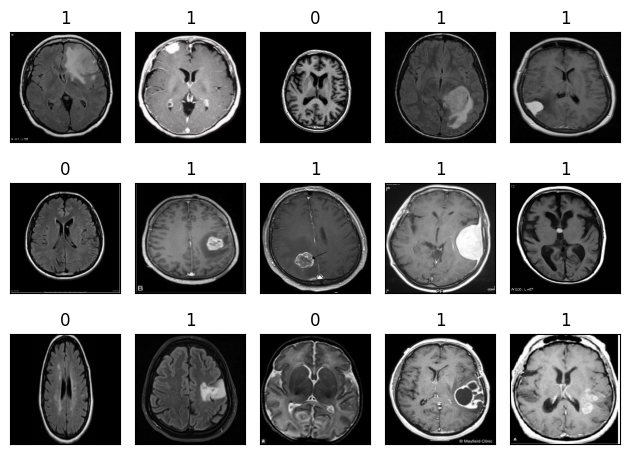

shape of X_train:  (224, 224, 3)
shape of X_test:  (224, 224, 3)
------------------------------------
number of samples in X_train:  169
number of samples in X_test:  84


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=309
)

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(int(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

print("shape of X_train: ", X_train[0].shape)
print("shape of X_test: ", X_test[0].shape)
print('------------------------------------')
print("number of samples in X_train: ", len(X_train))
print("number of samples in X_test: ", len(X_test))

In [51]:
# Load a VGG-16 as a prertained model
img_cols, img_rows = 224, 224

from keras.applications.vgg16 import VGG16
vgg = VGG16(weights='imagenet', # load the pretrained weights on the imagenet dataset because the model was trained on a similar dataset
            include_top=False, # because we are going to add our own layer and we have a different number of classes
            input_shape=(img_rows, img_cols, 3)) 

for layer in vgg.layers: # freeze the layers because we are using the pretrained model and we don't want to train it from scratch
    layer.trainable = False 
    
# print our layers
for (i, layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [52]:
from keras.models import Model

# Create a function to add a fully connected layers to the model
def addTopModel(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(num_classes, activation="softmax")(top_model)
    return top_model


In [53]:
num_classes = 2
FC_Head = addTopModel(vgg, num_classes)
model = Model(inputs=vgg.input, outputs=FC_Head)
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,981,250 (160.15 MB)

 Trainable params: 27,266,562 (104.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [54]:
print("y train shape: ", y_train.shape)
print("y train uniuqe values: ", np.unique(y_train))

print("y test shape: ", y_test.shape)   
print("y test uniuqe values: ", np.unique(y_test))

y train shape:  (169,)
y train uniuqe values:  [0 1]
y test shape:  (84,)
y test uniuqe values:  [0 1]


In [55]:
from keras.utils import to_categorical
from tensorflow.keras.models import Model

# One-hot encode the labels for multi-class classification
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Compile the model with categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [56]:
print(y_train.shape)
print(y_test.shape)

(169, 2)
(84, 2)


In [57]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.5784 - loss: 53.2327 - val_accuracy: 0.6071 - val_loss: 16.9502
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6671 - loss: 11.4833 - val_accuracy: 0.6905 - val_loss: 4.7858
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.7724 - loss: 3.4114 - val_accuracy: 0.7500 - val_loss: 3.9659
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.8728 - loss: 1.7685 - val_accuracy: 0.9167 - val_loss: 0.7843
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9462 - loss: 0.2295 - val_accuracy: 0.8929 - val_loss: 0.6017
